## Analysis of Price and Carbon Intensity of European Countries

In this notebook we present a short analysis of price and carbon intensity for European countries. We first pull data from the Electricity Map, we then display a simple scatterplot.

In [12]:
import arrow
from altair import *
import pandas as pd
import numpy as np
import requests
from utils import *

endpoint = 'http://www.electricitymap.org'
r = requests.session()

We will use the functions defined in the utils python file to fetch data from the Electricity Map. See [a README here](https://github.com/corradio/electricitymap/blob/master/datascience/README.md). 

We will use the functions `get_state` and `get_price` to return both carbon intensity and electricity price per country and per hour. 

In order to return all the countries available in the API, we use the function `fetch_state`:

In [88]:
# We return here a list of all countries in the Electricity Map 
state = fetch_state(arrow.get('2017-02-12'), 1440)
countries = state['countries'].keys()

We then pass this list of countries to our functions. Note that fetching 2 months of data at an hourly level for all countries will take a while. If you want to use exported csv, [you can download them from here](https://drive.google.com/open?id=0B7U9kYM5DOcaT1hZN3FTY1JsUTg)

In [189]:
# This will take a while to run. 
#prices = get_price(countries, '2017-01-22', '2017-02-20', 60)
#co2 = get_state(countries, '2017-01-22', '2017-02-20', 60)

#You can also import csv directly
prices = pd.read_csv('prices.csv', index_col=0)
co2 = pd.read_csv('co2.csv', index_col=0)

A quick look at the number of rows per country, suggest that we should do some data cleaning. In particular we have too little data points for GB and RO: 

In [173]:
prices.groupby('country').count().sort_values('price').head()

price  timestamp
country                  
RO           6          6
GB           6          6
PL         532        532
RS         533        533
CH         597        597

In [191]:
prices = prices[-prices['country'].isin(['RO', 'GB'])]

We also make sure to remove duplicates: 

In [202]:
co2 = co2.drop_duplicates(['country', 'timestamp'], keep='first')
prices = prices.drop_duplicates(['country', 'timestamp'], keep='first')

We also find that our price service is missing 20 countries out of 38 countries available in the Electricity Map. We display a list of countries below:  

In [261]:
pd.Series(countries)[-pd.Series(countries).isin(prices['country'].unique())]

2         BG
3         DK
4         HR
5         DE
7     GB-NIR
9         BY
10        BA
11        RU
14        NO
15        TR
18        RO
23        IT
24        AL
27        IE
29        ME
31        MK
33        MT
35        UA
36        SE
37        GB
dtype: object

We can now merge our two dataframes:

In [193]:
carbon_price = pd.merge(prices, co2, how='left', on=['country', 'timestamp'])
carbon_price.head()

country  price                  timestamp  co2intensity
0      BE  64.19  2017-01-22 09:00:00+00:00    207.934072
1      BE  66.88  2017-01-22 10:00:00+00:00    203.625372
2      BE  68.61  2017-01-22 11:00:00+00:00    199.630091
3      BE  69.24  2017-01-22 12:00:00+00:00    192.290279
4      BE  63.53  2017-01-22 13:00:00+00:00    199.612026

## Price Analysis

We can start by analyzing the price of electricity per country. We start by plotting timeseries for a subset of  countries. 

We notice the peak of price at the end of January in France or in Belgium: 

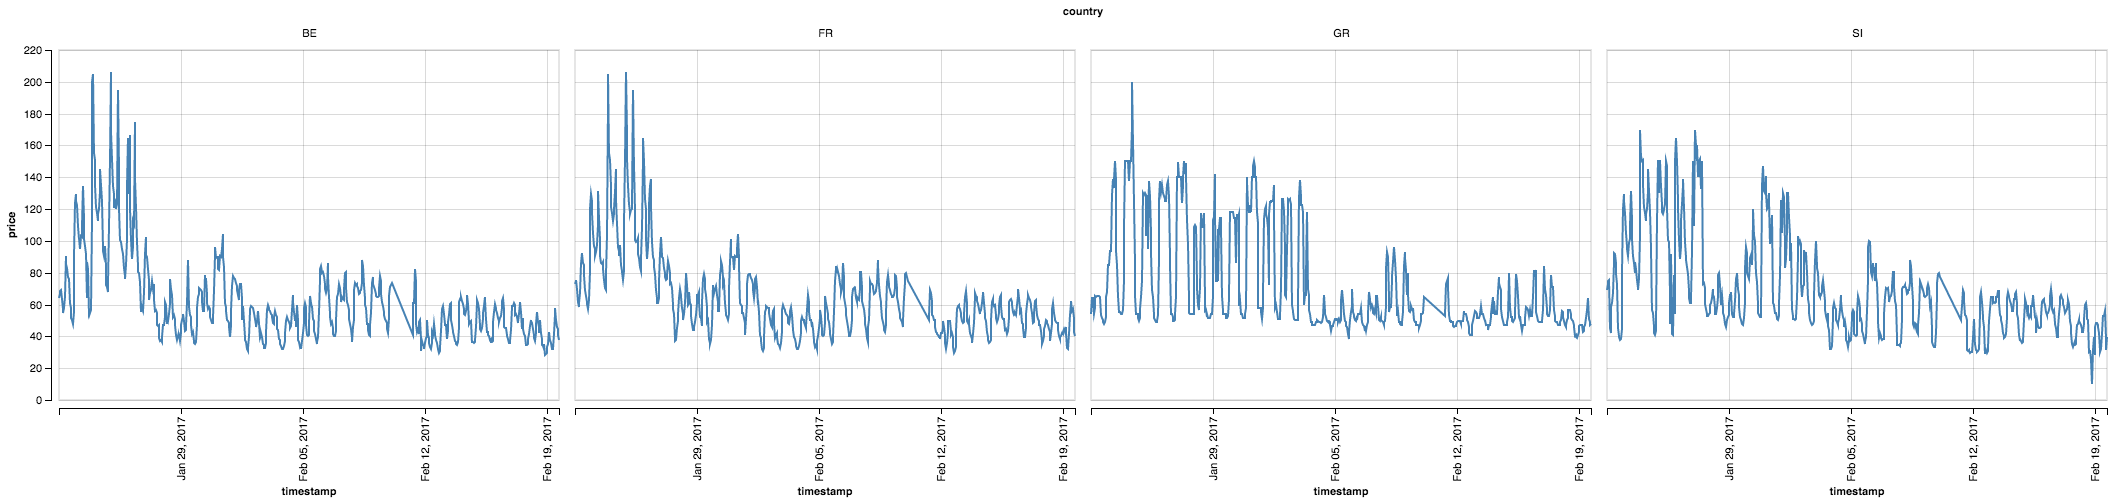

In [199]:
Chart(prices[prices['country'].isin(['GR', 'FR', 'BE', 'SI'])],
    description="Price of electricity (Euro per MWh) for four EU countries",
).mark_line(
).encode(
    column='country:N',
    x=X('timestamp:T'),
    y=Y('price:Q'),
)

We also notice the sharp variation of price for a given day. We know that electricity demand varies during the day. Let's then analyze price per hour during the day: 

In [203]:
# We create a new column with the hour of the day
def hour(t): 
    return arrow.get(t).hour

prices['hour'] = prices['timestamp'].apply(hour)

We can have a better view of the variation of the price of the electricity during the day in the erro bar graph below: 

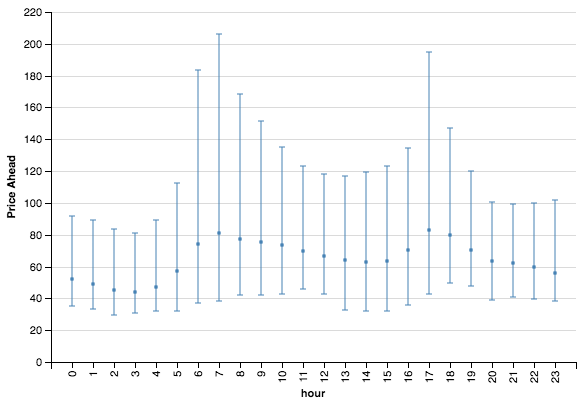

In [208]:
LayeredChart(prices,
    description='A error bar plot showing mean, min, and max of price for FR electricity production',
    layers=[Chart().mark_rule().encode(
            x='hour:O',
            y=Y('min(price):Q',
                axis=Axis(
                    title='Price Ahead',
                ),
            ),
            y2='max(price):Q',
        ), Chart().mark_tick().encode(
            size=Size(
                value=5.0,
            ),
            x='hour:O',
            y=Y('min(price):Q',
                axis=Axis(
                    title='Price Ahead',
                ),
            ),
        ), Chart().mark_tick().encode(
            size=Size(
                value=5.0,
            ),
            x='hour:O',
            y=Y('max(price):Q',
                axis=Axis(
                    title='Price Ahead',
                ),
            ),
        ), Chart().mark_point().encode(
            size=Size(
                value=2.0,
            ),
            x='hour:O',
            y=Y('mean(price):Q',
                axis=Axis(
                    title='Price Ahead',
                ),
            ),
        )],
).transform_data(
    filter=(expr.df.country == 'FR')
)


## Carbon Intensity Analysis 

It is also interesting to conduct the same analysis at the carbon intensity level. The strong variation of carbon intensity for a given day suggests for instance that a product like [co2signal](https://www.co2signal.com/): 

In [211]:
co2['hour'] = co2['timestamp'].apply(hour)

In [223]:
co2_hours = co2['co2intensity'].groupby([co2['country'], co2['hour']]).agg([np.min, np.mean, np.std, np.max]).reset_index()

We can then sort countries per the standard deviation of the carbon intensity for a given hour: 

In [227]:
co2_hours.sort_values('std', ascending=False).head()

country  hour        amin        mean         std   amax
434      ME    17  361.399177  556.300899  189.759448  820.0
436      ME    19  363.736082  565.188178  189.750714  820.0
427      ME    10  367.765199  596.047491  188.427394  820.0
429      ME    12  364.902954  640.479977  188.274434  820.0
435      ME    18  361.399177  545.518955  187.708227  820.0

It looks like the `Montenegro` shows a hight standard deviation, let's print a similar error bar for that country: 

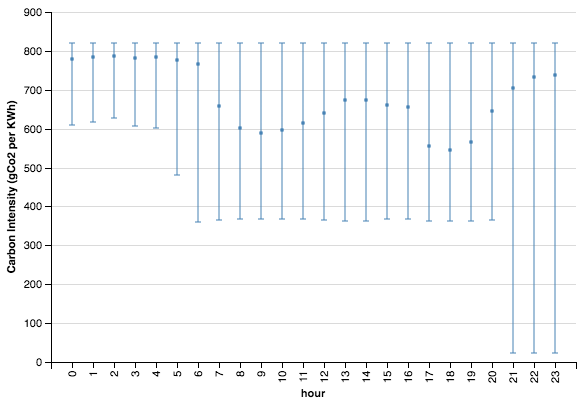

In [228]:
LayeredChart(co2,
    description='A error bar plot showing mean, min, and max of carbon intensity for ME electricity',
    layers=[Chart().mark_rule().encode(
            x='hour:O',
            y=Y('min(co2intensity):Q',
                axis=Axis(
                    title='Carbon Intensity (gCo2 per KWh)',
                ),
            ),
            y2='max(co2intensity):Q',
        ), Chart().mark_tick().encode(
            size=Size(
                value=5.0,
            ),
            x='hour:O',
            y=Y('min(co2intensity):Q',
                axis=Axis(
                    title='Carbon Intensity (gCo2 per KWh)',
                ),
            ),
        ), Chart().mark_tick().encode(
            size=Size(
                value=5.0,
            ),
            x='hour:O',
            y=Y('max(co2intensity):Q',
                axis=Axis(
                    title='Carbon Intensity (gCo2 per KWh)',
                ),
            ),
        ), Chart().mark_point().encode(
            size=Size(
                value=2.0,
            ),
            x='hour:O',
            y=Y('mean(co2intensity):Q',
                axis=Axis(
                    title='Carbon Intensity (gCo2 per KWh)',
                ),
            ),
        )],
).transform_data(
    filter=(expr.df.country == 'ME')
)

We should double check data sources here and especially understand if a bug in the data could explain the low carbon emissions of Montenegro. We print below the dates / hours for which the carbon intensity is the lowest: 

In [236]:
co2[co2['country'] == 'ME'].sort_values('co2intensity').head()

country  co2intensity                  timestamp  hour
13099      ME     24.000000  2017-02-09 21:00:00+00:00    21
13128      ME     24.000000  2017-02-09 22:00:00+00:00    22
13157      ME     24.000000  2017-02-09 23:00:00+00:00    23
13360      ME    360.384937  2017-02-10 06:00:00+00:00     6
15603      ME    361.399177  2017-02-13 18:00:00+00:00    18

Nonetheless, it is interesting to compare the variation of carbon intensity per hour with Norway, which has less variance for a given hour: 

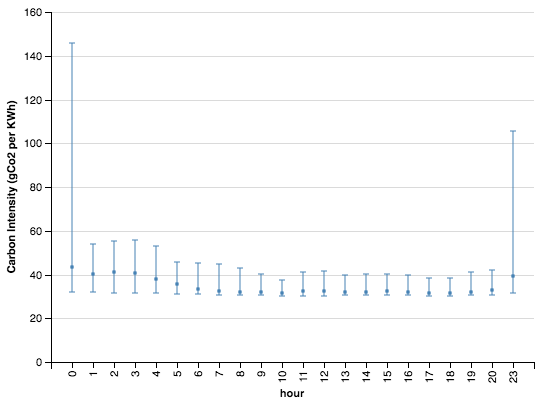

In [238]:
LayeredChart(co2,
    description='A error bar plot showing mean, min, and max of carbon intensity for NO electricity',
    layers=[Chart().mark_rule().encode(
            x='hour:O',
            y=Y('min(co2intensity):Q',
                axis=Axis(
                    title='Carbon Intensity (gCo2 per KWh)',
                ),
            ),
            y2='max(co2intensity):Q',
        ), Chart().mark_tick().encode(
            size=Size(
                value=5.0,
            ),
            x='hour:O',
            y=Y('min(co2intensity):Q',
                axis=Axis(
                    title='Carbon Intensity (gCo2 per KWh)',
                ),
            ),
        ), Chart().mark_tick().encode(
            size=Size(
                value=5.0,
            ),
            x='hour:O',
            y=Y('max(co2intensity):Q',
                axis=Axis(
                    title='Carbon Intensity (gCo2 per KWh)',
                ),
            ),
        ), Chart().mark_point().encode(
            size=Size(
                value=2.0,
            ),
            x='hour:O',
            y=Y('mean(co2intensity):Q',
                axis=Axis(
                    title='Carbon Intensity (gCo2 per KWh)',
                ),
            ),
        )],
).transform_data(
    filter=(expr.df.country == 'NO')
)

## Blending Price and Carbon

In this section we try to combine the analysis detailed above. In order to do this, we can build an index that captures the variation of the two metrics. 

We first start by plotting the average price and the average carbon intensity per country in a scatterplot: 

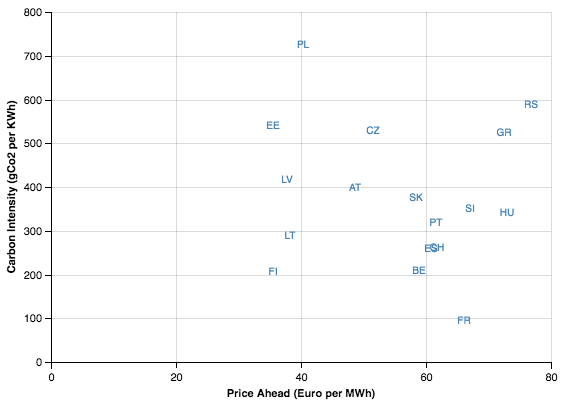

In [239]:
Chart(carbon_price,
     description = 'Scatterplot of price and carbon intensity for EU countries').mark_text().encode(
    x=X('mean(price):Q',
       axis=Axis(
            title='Price Ahead (Euro per MWh)',
        ),
    ),
    y=Y('mean(co2intensity):Q',
        axis=Axis(
            title='Carbon Intensity (gCo2 per KWh)',
        ),
    ),
    text='country'
)

It is also interesting to show the variation, both in terms of price and carbon intensity in few scatterplots. We present a subset of the countries in the scatterplots below: 

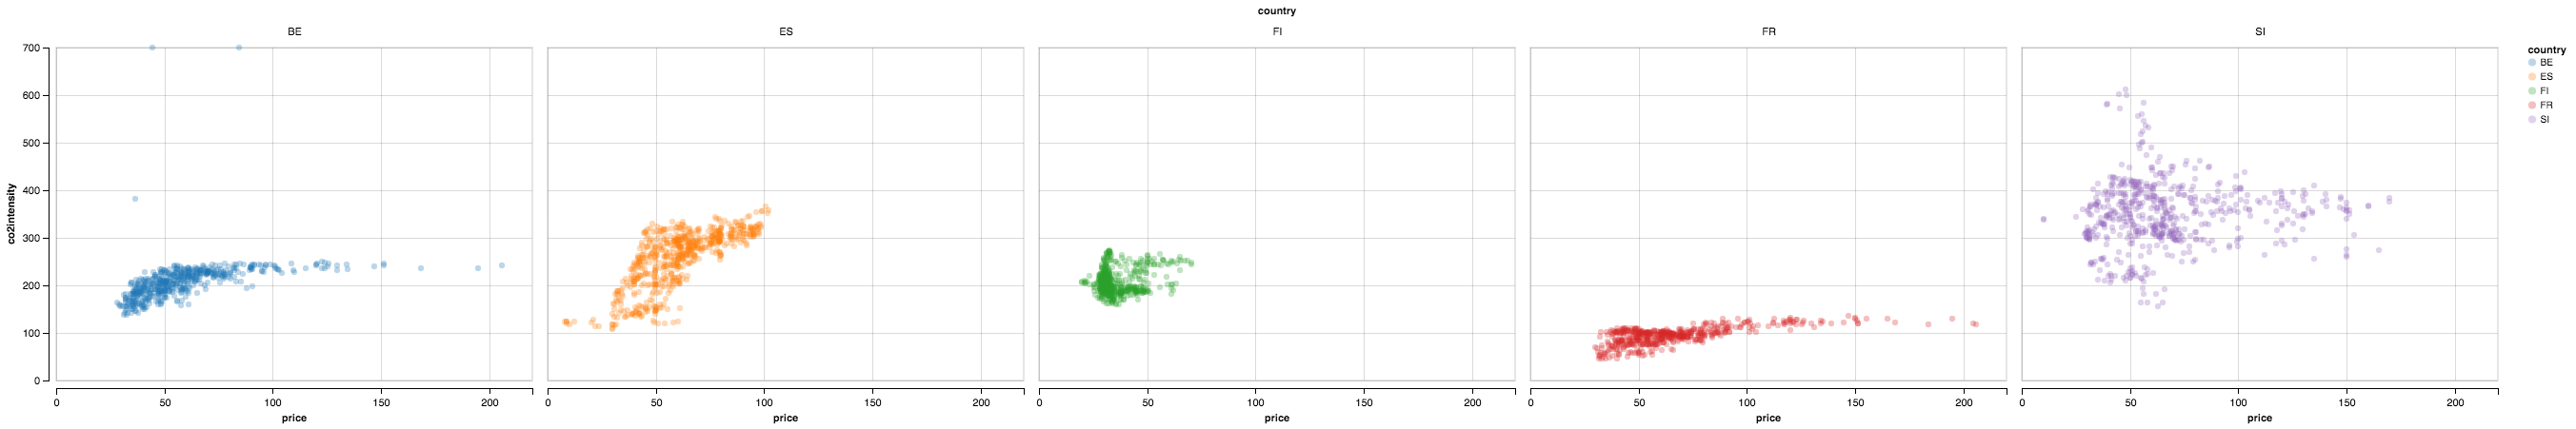

In [242]:
Chart(carbon_price[carbon_price['country'].isin(['ES', 'FR', 'BE', 'SI', 'FI'])],
    description="Price per country",
).mark_circle(
    opacity = 0.3,
).encode(
    column='country:N',
    x=X('price:Q'),
    y=Y('co2intensity:Q'),
    color='country:N'
)

Those charts raise different questions: 

- What could explain the variation in prices and carbon intensity? 
- How does the import / export of electricity at peak consumption play a role here? 

We can then blend both carbon intensity and price in one metric. We build this metric by simply dividing the carbon intensity by the price. This gives the `Amount (in Kg) of Co2 Emitted for 1 Euro Invested in Electricity`: 

In [267]:
carbon_price['euro_per_kg_carbon'] = carbon_price['co2intensity'] / carbon_price['price']

Below is a ranked bar chart per country: 

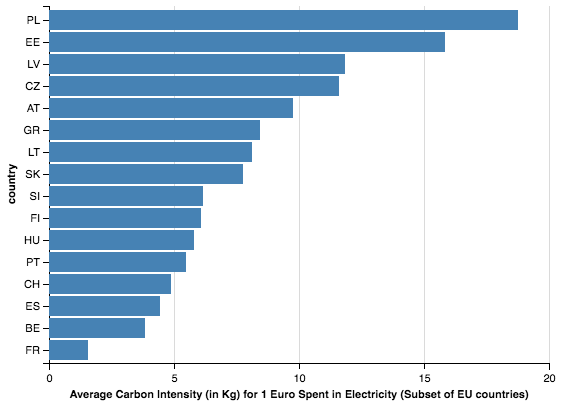

In [272]:
Chart(carbon_price['euro_per_kg_carbon'].groupby(carbon_price['country']).mean().reset_index(),
    description='A bar chart displaying the price (in euro) per carbon (in MWh) emitted by the electricity production',
).mark_bar().encode(
    x=X('euro_per_kg_carbon:Q',
        axis=Axis(
            title='Average Carbon Intensity (in Kg) for 1 Euro Spent in Electricity (Subset of EU countries)',
        ),
    ),
    y=Y('country:N',  sort=SortField(field='euro_per_kg_carbon', order='descending', op='sum')),
)

In [269]:
carbon_price['hour'] = carbon_price['timestamp'].apply(hour)

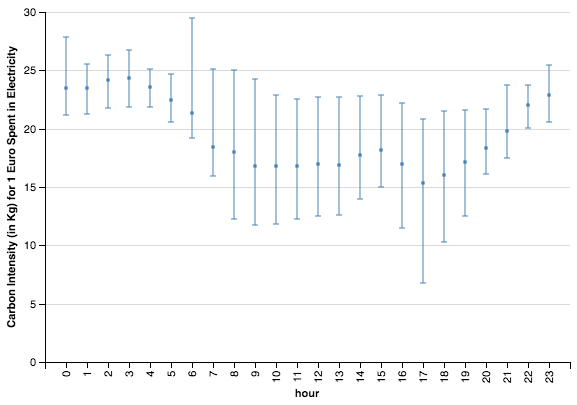

In [273]:
LayeredChart(carbon_price,
    description='A error bar plot showing mean, min, and max of carbon intensity for NO electricity',
    layers=[Chart().mark_rule().encode(
            x='hour:O',
            y=Y('min(euro_per_kg_carbon):Q',
                axis=Axis(
                    title='Carbon Intensity (in Kg) for 1 Euro Spent in Electricity',
                ),
            ),
            y2='max(euro_per_kg_carbon):Q',
        ), Chart().mark_tick().encode(
            size=Size(
                value=5.0,
            ),
            x='hour:O',
            y=Y('min(euro_per_kg_carbon):Q',
                axis=Axis(
                    title='Carbon Intensity (in Kg) for 1 Euro Spent in Electricity',
                ),
            ),
        ), Chart().mark_tick().encode(
            size=Size(
                value=5.0,
            ),
            x='hour:O',
            y=Y('max(euro_per_kg_carbon):Q',
                axis=Axis(
                    title='Carbon Intensity (in Kg) for 1 Euro Spent in Electricity',
                ),
            ),
        ), Chart().mark_point().encode(
            size=Size(
                value=2.0,
            ),
            x='hour:O',
            y=Y('mean(euro_per_kg_carbon):Q',
                axis=Axis(
                    title='Carbon Intensity (in Kg) for 1 Euro Spent in Electricity',
                ),
            ),
        )],
).transform_data(
    filter=(expr.df.country == 'PL')
)

## Next Steps

As next steps, it would be interesting to: 
- Break down electricity production by sources and investigate high / low price point per electricity mix.
- Get data for missing countries. 
- Add import and export countries data 